# Compute Architecure - Assessment
**Course**: TU 2025 25-26: 8645 -- COMPUTER INFRASTRUCTURE  
**Lecturer**: Ian McLauglin  
**Author**: Clyde Watts  





## Table of Contents

[Summary](#summary)   
[Problem Part   I](#assignment-problem-1-requirements-specification)   
[Problem Part  II](#assignment-problem-2-requirements-specification)    
[Problen Part III](#assignment-problem-3-requirements-specification) 


## Summary

The object of the Compute Architecture - Assessment , is to create a notebook ( problems.ipynb ) and an associated python script , which will export the FAANG share prices using yfinance for the last 5 business days and then load the files , and produce a report of the closing prices. 



![DataFlow](./faang_dataflow.png)




### Imports

yfinance - financial ticker data from yahoo  - [yfinance](https://github.com/ranaroussi/yfinance)
datetime - pythons inbuild date time
logging - python logging
os - operating system functions
glob - file selector

In [1]:

import logging
from datetime import datetime, timedelta
import os
import pathlib as Path
import glob
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 
import seaborn as sns
import numpy as np
import yfinance as yf

##  Initialisation

In [2]:
# init logging
logging.basicConfig(level=logging.INFO)

In [3]:
# Delete all CSV files in the data directory
data_path = "./data/"
files = glob.glob(os.path.join(data_path, "*.csv"))
for f in files:
    print(f"Deleting file: {f}")
    os.remove(f)

Deleting file: ./data\20251129_141931.csv
Deleting file: ./data\20251202_195008.csv


### Helper Functions 




__Function: print_status__

Prints the status with a green tick or red cross. This makes it easier to validate function return codes

In [4]:





def print_status(return_code, description, return_message)-> None:
    """
    Print status with visual indicator
    
    Args:
        return_code (int): 0 for success, non-zero for failure
        description (str): Status description
        return_message (str): Related file name
    """
    if return_code == 0:
        # Green tick for success (bold)
        status_symbol = "\033[1;92m✓\033[0m"  # Bold green checkmark
    else:
        # Red X for failure (bold)
        status_symbol = "\033[1;91m✗\033[0m"  # Bold red X

    # Print entire line in bold
    print(f"\033[1m{status_symbol} Status: {return_code}, Message: {description}, File: {return_message}\033[0m")


__Smoke Test__

Check if print status will work

In [5]:
print("Smoke Test Results:")
print_status(0, "Latest file retrieval", "file_name.csv")
print_status(1, "File retrieval failed", "file_name.csv")

Smoke Test Results:
✓ Status: 0, Message: Latest file retrieval, File: file_name.csv
✗ Status: 1, Message: File retrieval failed, File: file_name.csv


__Function : diagnose_difference__

This function compares to dataframes from structural as well as data similarity. It is to validate if export and load process produce the same dataframe.

After the lecture on loading csv , and the issue of the original and loaded csv differences. I used gemeni 3 and prompted for , _how would i compare the difference between the original dataframe and the exported and imported data frame in pandas_

Note: 

There are alteratives to csv which do preserve the data structure , pickle or parquet. If I was implementing in production I would use parquet , or maybe invent iceberg or datalake.

In [6]:
def diagnose_differences(df_original, df_loaded)-> None:
    """
    Compares two DataFrames and prints a readable report of differences.
    """
    print("--- DIAGNOSTIC REPORT ---")
    
    # 1. Check Shape
    if df_original.shape != df_loaded.shape:
        print(f"❌ SHAPE MISMATCH: Original {df_original.shape} vs Loaded {df_loaded.shape}")
        return # Stop if shapes don't match
    else:
        print("✅ Shapes match")

    # 2. Check Index
    try:
        pd.testing.assert_index_equal(df_original.index, df_loaded.index)
        print("✅ Indices match")
    except AssertionError:
        print("❌ INDEX MISMATCH: The indices are different.")
        print(f"   Original type: {type(df_original.index)}")
        print(f"   Loaded type:   {type(df_loaded.index)}")

    # 3. Check Column Data Types (The most common CSV failure)
    print("\n--- CHECKING DTYPES ---")
    mismatches = 0
    for col in df_original.columns:
        dtype_orig = df_original[col].dtype
        dtype_load = df_loaded[col].dtype
        
        if dtype_orig != dtype_load:
            print(f"⚠️ TYPE MISMATCH in '{col}': {dtype_orig} (Original) -> {dtype_load} (Loaded)")
            mismatches += 1
    
    if mismatches == 0:
        print("✅ All data types match")

    # 4. Strict Equality Check (Values)
    print("\n--- STRICT EQUALITY ---")
    try:
        # check_dtype=False allows us to see if values match even if types don't (e.g. int vs float)
        pd.testing.assert_frame_equal(df_original, df_loaded, check_dtype=True)
        print("🎉 SUCCESS: DataFrames are identical!")
    except AssertionError as e:
        print("❌ VALUE/STRICT CHECK FAILED.")
        print("   (CSV often changes float precision or converts Ints to Floats if NaNs exist)")

# --- USAGE EXAMPLE ---

# 1. Create a complex DataFrame
df = pd.DataFrame({
    'date': pd.to_datetime(['2023-01-01', '2023-01-02']),
    'integer': [1, 2],
    'float': [1.123456789, 2.5],
    'text': ['hello', 'world']
})


__Smoke Test__

In [7]:

# 2. The "Bad" Round Trip (Standard CSV)
df.to_csv('test.csv', index=False)
df_loaded_csv = pd.read_csv('test.csv')

# 3. Run Diagnostic
diagnose_differences(df, df_loaded_csv)

# cleanup
os.remove('test.csv')

--- DIAGNOSTIC REPORT ---
✅ Shapes match
✅ Indices match

--- CHECKING DTYPES ---
⚠️ TYPE MISMATCH in 'date': datetime64[ns] (Original) -> object (Loaded)

--- STRICT EQUALITY ---
❌ VALUE/STRICT CHECK FAILED.
   (CSV often changes float precision or converts Ints to Floats if NaNs exist)


__Function: data_retention__

This will cleanup data , plot and log directories old files ( older than 21 days )

In [ ]:
def data_retention(old_days=21)-> tuple[int, str]:
    """
    This will cleanup data , plot and log directories old files ( older than old_days )
    
    Args:
        old_days (int): Number of days to retain files. Files older than this will be deleted.
    """
    return_code = 0
    return_message = "Data retention completed successfully."
    # Define directories to clean
    directories = ["./data/", "./plots/", "./logs/"]
    # Get current date
    now = datetime.now()
    # Calculate cutoff date
    cutoff_date = now - timedelta(days=old_days)
    # loop over directories
    for directory in directories:
        # Ensure directory exists
        Path.Path(directory).mkdir(parents=True, exist_ok=True)
        # loop over files in directory
        for file_path in Path.Path(directory).glob("*"):
            # Get file's last modified time
            file_mod_time = datetime.fromtimestamp(file_path.stat().st_mtime)
            # If file is older than cutoff date, delete it
            if file_mod_time < cutoff_date:
                print(f"Deleting old file: {file_path} (Last modified: {file_mod_time})")
                file_path.unlink()  # Delete the file
    return return_code,  return_message

__Smoke Test__

Check if there are any plot , data and log files older 21 days and delete

In [9]:
return_code, return_message = data_retention(old_days=21)
print_status(return_code, "Data Retention Cleanup", return_message)

Deleting old file: logs\faang_20251109_212959.log (Last modified: 2025-11-09 21:29:59.631564)
Deleting old file: logs\faang_20251109_213234.log (Last modified: 2025-11-09 21:32:34.336259)
Deleting old file: logs\faang_20251109_213332.log (Last modified: 2025-11-09 21:33:32.672651)
✓ Status: 0, Message: Data Retention Cleanup, File: Data retention completed successfully.


## Problem 1: Data from yfinance

Using the [yfinance](https://github.com/ranaroussi/yfinance) Python package, write a function called `get_data()` that downloads all hourly data for the previous five days for the five FAANG stocks:

- Facebook (META)
- Apple (AAPL)
- Amazon (AMZN)
- Netflix (NFLX)
- Google (GOOG)

The function should save the data into a folder called `data` in the root of your repository using a filename with the format `YYYYMMDD-HHmmss.csv` where `YYYYMMDD` is the four-digit year (e.g. 2025), followed by the two-digit month (e.g. `09` for September), followed by the two digit day, and `HHmmss` is hour, minutes, seconds.
Create the `data` folder if you don't already have one.

## Problem 1: Requirements ##

### Extract ###

1.  Extract from yfinance data the stock data for META,AAPL,AMZN,NFLX,GOOG
2.  For 5 complete previous days trading , we need to take into account that NASDAQ trades from Monday to Friday. If we go back 7 days we will always ignore weekends
3.  File format will YYYYMMDD-HHmmss.csv where YYYY - is 4 digit year , MM month 01-12 , DD - is 01-31. HH - hours , 24 our clock , mm - minutes 00-59 , seconds 00-59.
4.  Grain - Hour

__Columns__

- Date , <ticket> ( Open,High,Low,Close,Volume) ....
ticket is META , AAPL , AMZN , NFLX or GOOG
- Open - open price
- Close - close price
- High - High pricr
- Low - Low price
- Volumn - Volume in period

The data frame return has an index on the date , and is a multilevel index. Level one is the ticket , and the second level is the metric - that is open , close , high , low prices and volume 

Note: AI was used to generate the checklist , the author likes the style. The checklist was not used as a prompt to generate the code.

### Assignment: Problem 1 Requirements Specification

**1. Data Specification**
* [✅] Define the list of target tickers: META, AAPL, AMZN, NFLX, and GOOG.
* [✅] Define the data interval as "hourly".
* [✅] Define the data period as the "previous five days".

**2. Data Fetching**
* [✅] Use the `yfinance` Python package.
* [✅] Write code to download the data for all five tickers based on the interval and period.
* [✅] Store the downloaded data, likely in a `pandas` DataFrame.

**3. Folder Management**
* [✅] Check if a folder named `data` exists in the root of the repository.
* [✅] If the `data` folder does not exist, create it.

**4. File Output**
* [✅] Get the current date and time.
* [✅] Format the current date and time into a string `YYYYMMDD-HHmmss`.
* [✅] Create the full output path by combining the `data` folder, the formatted datetime string, and the `.csv` extension.
* [✅] Save the downloaded data DataFrame to this CSV file.



__Global Parameters__

tickers - this is a list of stocks short names of interest

In [10]:
# List of tickers to download
tickers = ["META", "AAPL", "AMZN", "NFLX", "GOOG"]

__Function : get_data__

This downloads the latest data for a number of listed stock companies using yfinance module and writes to CSV file. 

In [11]:

def get_data(tickers = tickers,start_date=None, end_date=None,interval="1h",data_path="./data/",once_only=True)-> tuple[int, str, str, pd.DataFrame]:
    """
    Function to get stock data from yfinance

    Parameters:
    tickers (list): List of stock tickers to download data for
    start_date (str): Start date for data in format "YYYY-MM-DD". If None, defaults to 6 days ago.
    end_date (str): End date for data in format "YYYY-MM-DD". If None, defaults to yesterday.
    interval (str): Data interval. Default is "1h".
    data_path (str): Path to save the data. Default is "./data/".
    once_only (bool): If True, download data only once for a date and do not overwrite existing files. Default is True.
    If set to false it will delete existing files and download again.
    TODO: add only once functionality
    Returns:
       return_code : 0 for success, -1 for failure
       return_message : message indicating success or failure
       file_name (str): Name of the file where data is saved
    """
    return_code = 0
    return_message = "Success"
    file_name = None
    df_data = None
    # TODO : implement once_only functionality
    # TODO : Sort out logic of start_date and end_date for once only check , simplify
    # Get current date and time and keep it constant
    now_dttm = datetime.now()
    # if start_date is None , set to today - 7 days
    start_date_dttm =(now_dttm - timedelta(days=7)) if start_date is None else datetime.strptime(start_date, "%Y-%m-%d")
    start_date = start_date_dttm.strftime("%Y-%m-%d") if start_date is None else start_date
    start_date_dttm = datetime.strptime(start_date, "%Y-%m-%d")
    # create file name from start date
    file_name = f"{data_path}{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
    # create string for glob to check if file exists for start date
    start_date_glob_str = f"{data_path}{datetime.now().strftime('%Y%m%d')}*.csv"
    if once_only and glob.glob(start_date_glob_str):
        logging.info(f"File already exists for start date {start_date}, skipping download.")
        existing_files = glob.glob(start_date_glob_str)
        file_name = existing_files[0]  # Get the first matching file
        return return_code, return_message, file_name, None

        
    # if end_date is None , set to today - 0 days this means yesterday's data inclusive
    if end_date is None:
        end_date = (datetime.now() - timedelta(days=0)).strftime("%Y-%m-%d")
    else: # convert end_date to datetime object
        end_date_time = datetime.strptime(end_date, "%Y-%m-%d")
        # add 1 day to end_date to make it inclusive
        end_date = (end_date_time + timedelta(days=1)).strftime("%Y-%m-%d")
    # check if directory exists
    if not os.path.exists(data_path):
        logging.info(f"Creating directory: {data_path}")
        try:
            os.makedirs(data_path)
        except Exception as e:
            logging.error(f"Error creating directory: {e}")
            return_code = -1
            return_message = f"Error creating directory: {e}"
            return return_code, return_message, None, None
    # get start date only string for file name for once only check

    # if file exists then delete it
    if os.path.exists(file_name):
        logging.info(f"Deleting existing file: {file_name}")
        try:
            os.remove(file_name)
        except Exception as e:
            logging.error(f"Error deleting file: {e}")
            return_code = -1
            return_message = f"Error deleting file: {e}"
            return return_code, return_message, None, None
    logging.info(f"Start Date: {start_date}, End Date: {end_date}")
    try:
        df_data = yf.download(tickers, interval=interval, group_by='ticker',start=start_date, end=end_date,auto_adjust=True)
    except Exception as e:
        logging.error(f"Error downloading data: {e}")
        return_code = -1
        return_message = f"Error downloading data: {e}"
        return return_code, return_message, None, None
    # Save the data to a CSV file
    df_data.to_csv(file_name)
    return return_code, return_message, file_name,df_data
   



__Smoke Test__

Validate that the function does not abend.

In [12]:
print("Starting data download...")
return_code, return_message, file_name , df_data = get_data(tickers=tickers,once_only=False)
print_status(return_code, return_message, file_name)
# check if file exists
if return_code == 0 and file_name is not None and os.path.exists(file_name):
    print_status(0,f"Data downloaded and saved to {file_name}", file_name)
else:
    print_status(-1,"Data download failed.", None)

INFO:root:Start Date: 2025-11-25, End Date: 2025-12-02


Starting data download...


[*********************100%***********************]  5 of 5 completed

✓ Status: 0, Message: Success, File: ./data/20251202_203257.csv
✓ Status: 0, Message: Data downloaded and saved to ./data/20251202_203257.csv, File: ./data/20251202_203257.csv


## Problem 2: Plotting Data

Write a function called `plot_data()` that opens the latest data file in the `data` folder and, on one plot, plots the `Close` prices for each of the five stocks.
The plot should include axis labels, a legend, and the date as a title.
The function should save the plot into a `plots` folder in the root of your repository using a filename in the format `YYYYMMDD-HHmmss.png`.
Create the `plots` folder if you don't already have one.


### Assignment: Problem 2 Requirements Specification

Here is a checklist of all the tasks the `plot_data()` function must accomplish:

**1. File Input & Data Loading**
* [✅] Access the `data` folder.
* [✅] Identify the *latest* file in the `data` folder (e.g., by checking file modification time or finding the most recent date in the filename).
* [✅] Open and read the data from this file (assuming it's a format like CSV, likely using `pandas`).

**2. Data Processing**
* [✅] Extract the `Close` price columns for all five stocks.
* [✅] Ensure the corresponding date/time data is available to be used for the x-axis.

**3. Plot Generation & Styling**
* [✅] Create a *single* plot figure.
* [✅] Plot all five `Close` price series as lines on this single plot.
* [✅] Set a clear label for the x-axis (e.g., "Date").
* [✅] Set a clear label for the y-axis (e.g., "Closing Price ($)").
* [✅] Add a legend that correctly identifies each of the five stocks.
* [✅] Get the *current* date and time.
* [✅] Set the plot's title to the current date (e.g., "Stock Prices as of YYYY-MM-DD").

**4. File Output**
* [✅] Check if a folder named `plots` exists in the root directory.
* [✅] If the `plots` folder does not exist, create it.
* [✅] Generate a filename based on the current date and time in `YYYYMMDD-HHmmss` format (e.g., `20251109-161120`).
* [✅] Save the generated plot to the `plots` folder using the generated filename with a `.png` extension.
* [✅] Ensure the plot is closed after saving to free up resources.



[glob function](https://docs.python.org/3/library/glob.html)



__Function : get_the_latest_file__

This scans directory ./data ( parameter ) using a pattern 20....csv to get the latest file and returns the file name

In [13]:
#------------------------------------------------------------------------------
# Function to get the latest file from a directory
#------------------------------------------------------------------------------

def get_latest_file(data_path="./data/")-> tuple[int, str, str]:
    """
    Returns the path to the latest data file in the specified directory.

    Args:
        data_path (str): The path to the directory containing the data files.

        tuple: (return_code, return_message, latest_file) where latest_file is the path to the latest data file, or None if no files are found.
        str: The path to the latest data file, or None if no files are found.
    """
    return_code = 0
    return_message = "Success"
    latest_file = None

    logging.info(f"Getting the latest file from {data_path}")
    # File pattern
    file_pattern = "20[0-9][0-9][0-1][0-9][0-3][0-9]_[0-9][0-9][0-9][0-9][0-9][0-9].csv"
    # Add path to file pattern
    file_pattern = os.path.join(data_path, file_pattern)
    # glob searches directories for files based on a pattern
    try:
        list_of_files = glob.glob(file_pattern)
    except Exception as e:
        logging.error(f"Error occurred while searching for files: {e}")
        return_code=-1
        return_message=f"Error occurred while searching for files: {e}"
        return return_code, return_message, None
    if not list_of_files:
        logging.warning(f"No files found in {data_path} matching pattern {file_pattern}")
        return_code = -1
        return_message = f"No files found in {data_path} matching pattern {file_pattern}"
        return return_code, return_message, None
    # find the latest file based on creation time
    #    max parameters - list and function which gets "value" associated with each item in the list
    #    this gets the "youngest" file based on creation time 
    #    not necessarily the latest date in the file name - design decision 
    #    the premise is that the latest file created is the one we want to use
    latest_file = max(list_of_files, key=os.path.getctime)
    logging.info(f"Latest file: {latest_file}")
    return return_code, return_message, latest_file

__Function: get_PNG_filename_from_CSV_filename__

This function will return the png file name based on csv file name

In [14]:
def get_PNG_filename_from_CSV_filename(csv_filename,plot_path="./plots/")-> tuple[int, str, str]:
    """
    Function to get PNG filename from CSV filename

    Parameters:
    csv_filename (str): Name of the CSV file
    plot_path (str): Path to save the PNG file. Default is "./plots/".

    Returns:
       png_filename (str): Name of the PNG file
    """
    return_code = 0
    return_message = "Success"
    # extract base name from csv_filename
    base_name = os.path.basename(csv_filename)
    # remove .csv extension
    base_name = os.path.splitext(base_name)[0]
    # create png filename
    png_filename = f"{plot_path}{base_name}.png"
    return return_code, return_message, png_filename

__Smoke Test__

Run both functions , get_lastest_file and convert name from CSV to PNG

In [15]:
return_code, return_message, file_name = get_latest_file()
print_status(return_code, f"Latest file retrieval - Return Code: {return_code}, Message: {return_message}, File: {file_name}", return_message)
# now get png file name from csv file name
return_code, return_message, png_file_name = get_PNG_filename_from_CSV_filename(file_name, "./plots/")
print_status(return_code, f"PNG file path retrieval - Return Code: {return_code}, Message: {return_message}, File: {png_file_name}", return_message)


INFO:root:Getting the latest file from ./data/
INFO:root:Latest file: ./data\20251202_203257.csv


✓ Status: 0, Message: Latest file retrieval - Return Code: 0, Message: Success, File: ./data\20251202_203257.csv, File: Success
✓ Status: 0, Message: PNG file path retrieval - Return Code: 0, Message: Success, File: ./plots/20251202_203257.png, File: Success


__Function : load_file_into_dataframe__

This loads the file name into data frame

In [16]:
def load_file_into_dataframe(file)-> tuple[int, str, pd.DataFrame]:
    """load_file_into_dataframe

    Args:
        file (str): The path to the data file.

    Returns:
        tuple: (return_code, return_message, df) where:
            return_code (int): 0 for success, -1 for failure
            return_message (str): Success or error message
            df (pd.DataFrame): The data as a pandas DataFrame with multi-level columns
    """
    return_code = 0
    return_message = "Success"
    df = None
    
    # Check if file name is provided
    if file is None:
        logging.error("No file provided to load into dataframe.")
        return_code = -1
        return_message = "No file provided to load into dataframe."
        return return_code, return_message, None
    
    # Check if file exists
    if not os.path.exists(file):
        logging.error(f"File does not exist: {file}")
        return_code = -1
        return_message = f"File does not exist: {file}"
        return return_code, return_message, None
    
    # Load the CSV file into a DataFrame with multi-level columns
    try:
        df = pd.read_csv(file, header=[0,1], index_col=0, parse_dates=True)
        logging.info(f"Successfully loaded data from {file}. Shape: {df.shape}")
    except Exception as e:
        logging.error(f"Error loading file {file}: {e}")
        return_code = -1
        return_message = f"Error loading file {file}: {e}"
        return return_code, return_message, None
    
    return return_code, return_message, df



__Smoke Test__

Check the following

1. Get the latest file
2. Load latest file into data frame
3. Convert CSV file name into PNG file name
4. Print Shape
5. Validate Structure

In [17]:
# Get file data before loading from csv
print("Get file data before loading from csv...")
return_code,return_message,before_file_name,df_before = get_data(tickers=tickers, once_only=False)
print_status(return_code, f"Data download before load - Return Code: {return_code}, Message: {return_message}", None)
print("Loading data from the latest file...")
return_code, return_message, latest_file = get_latest_file()
full_file_name = os.path.abspath(latest_file)
print(f"Loading data from file: {full_file_name}")
print_status(return_code, f"Latest file retrieval - Return Code: {return_code}, Message: {return_message}, File: {latest_file}", return_message)    
print("Loading file into dataframe...")
return_code, return_message, df = load_file_into_dataframe(latest_file)
print_status(return_code, f"File load - Return Code: {return_code}, Message: {return_message}, File: {latest_file}", return_message)    

print(f"Dataframe shape: {df.shape}")
# convert csv file name to png file name
return_code, return_message, png_file_path = get_PNG_filename_from_CSV_filename(latest_file, "./plots/")
print(f"PNG file path: {png_file_path}")
# calibrate structures , before and after loading from csv
diagnose_differences(df_before, df)



INFO:root:Start Date: 2025-11-25, End Date: 2025-12-02
[*********************100%***********************]  5 of 5 completed
INFO:root:Getting the latest file from ./data/
INFO:root:Latest file: ./data\20251202_203303.csv


Get file data before loading from csv...
✓ Status: 0, Message: Data download before load - Return Code: 0, Message: Success, File: None
Loading data from the latest file...
Loading data from file: c:\Users\cw171001\OneDrive - Teradata\Documents\GitHub\PFDA_computer_architecture\data\20251202_203303.csv
✓ Status: 0, Message: Latest file retrieval - Return Code: 0, Message: Success, File: ./data\20251202_203303.csv, File: Success
Loading file into dataframe...


INFO:root:Successfully loaded data from ./data\20251202_203303.csv. Shape: (24, 25)


✓ Status: 0, Message: File load - Return Code: 0, Message: Success, File: ./data\20251202_203303.csv, File: Success
Dataframe shape: (24, 25)
PNG file path: ./plots/20251202_203303.png
--- DIAGNOSTIC REPORT ---
✅ Shapes match
✅ Indices match

--- CHECKING DTYPES ---
✅ All data types match

--- STRICT EQUALITY ---
🎉 SUCCESS: DataFrames are identical!


### Investigate Data Frame

Have a look at the dataframe and see it's structure. 

https://ranaroussi.github.io/yfinance/reference/api/yfinance.download.html#yfinance.download

The index is DatetimeIndex - that is the timestamp of the price.
The data appears Company/Ticker - and then metrics - open,high,low,close,volume



In [18]:
# Have a look at the index and columns
print(" Data Frame Info")
print(df.info(verbose=True))

 Data Frame Info
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24 entries, 2025-11-25 14:30:00+00:00 to 2025-12-01 20:30:00+00:00
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (AAPL, Open)    24 non-null     float64
 1   (AAPL, High)    24 non-null     float64
 2   (AAPL, Low)     24 non-null     float64
 3   (AAPL, Close)   24 non-null     float64
 4   (AAPL, Volume)  24 non-null     int64  
 5   (META, Open)    24 non-null     float64
 6   (META, High)    24 non-null     float64
 7   (META, Low)     24 non-null     float64
 8   (META, Close)   24 non-null     float64
 9   (META, Volume)  24 non-null     int64  
 10  (NFLX, Open)    24 non-null     float64
 11  (NFLX, High)    24 non-null     float64
 12  (NFLX, Low)     24 non-null     float64
 13  (NFLX, Close)   24 non-null     float64
 14  (NFLX, Volume)  24 non-null     int64  
 15  (AMZN, Open)    24 non-null     float64
 16  (AMZN, High)   

Check the first and last dates . To check if the week is being covered.
That is the fense post problem.

_Note:_ The code is not catering for bank holiday - I was caught out for thanks giving day 

In [19]:
# Only get the datetime index and convert to a list
datetime_index = df.index.to_series().reset_index(drop=True)
# Convert series datetime to dates and remove duplicates and sort
date_list = datetime_index.dt.date.drop_duplicates().sort_values().astype(str)
# the date list should include 5 trading days for hourly data over a week
print("Trading Dates in Data:")
print(date_list)
if len(date_list) != 5:
    print_status(-1, "Unexpected number of trading days", f"Expected 5 trading days, but got {len(date_list)} days.")
    print(f"Warning: Expected 5 trading days, but got {len(date_list)} days.")
else:
    print_status(0, "Correct number of trading days", f"Got {len(date_list)} trading days as expected.")

Trading Dates in Data:
0     2025-11-25
7     2025-11-26
14    2025-11-28
17    2025-12-01
Name: Datetime, dtype: object
✗ Status: -1, Message: Unexpected number of trading days, File: Expected 5 trading days, but got 4 days.


Investigate the time zones , the data is from US NASDAQ - Monday to Friday 9:30 to 21:30 EST , UTC+8

https://www.ig.com/en/trading-strategies/nasdaq-opening-and-closing-times--when-can-you-trade--230527#:~:text=The%20index%20opens%20at%209.30,that's%204%20am%20UTC%2B8.&text=However%2C%20you%20can%20trade%20the,a%20day%2C%20Monday%20to%20Thursday.

In [20]:
# Only get the datetime index and convert to a list
datetime_index = df.index.to_series().reset_index(drop=True)
# Extract the time zone info
time_zone = datetime_index.dt.tz
print(f"Time Zone Info: {time_zone}")
# Extract time from datetime index
time_list = datetime_index.dt.time.drop_duplicates().sort_values().astype(str)
print("Time List:")
print(time_list)
# see if the convert the timezone to EST for NASDAQ data is possible
datetime_index_est = datetime_index.dt.tz_convert('US/Eastern')
print("Datetime Index in EST:")
time_list_est = datetime_index_est.dt.time.drop_duplicates().sort_values().astype(str)
print("Time List in EST:")
print(time_list_est)

Time Zone Info: UTC
Time List:
0    14:30:00
1    15:30:00
2    16:30:00
3    17:30:00
4    18:30:00
5    19:30:00
6    20:30:00
Name: Datetime, dtype: object
Datetime Index in EST:
Time List in EST:
0    09:30:00
1    10:30:00
2    11:30:00
3    12:30:00
4    13:30:00
5    14:30:00
6    15:30:00
Name: Datetime, dtype: object


In [21]:
print("Loading data from the latest file...")
return_code, return_message, latest_file = get_latest_file()
print_status(return_code, f"Latest file retrieval - Return Code: {return_code}, Message: {return_message}, File: {latest_file}", return_message)    

return_code, return_message, df = load_file_into_dataframe(latest_file)
print_status(return_code, f"File load - Return Code: {return_code}, Message: {return_message}, File: {latest_file}", return_message)    

print(df.shape)
# convert csv file name to png file name
return_code, return_message, png_file_path = get_PNG_filename_from_CSV_filename(latest_file, "./plots/")
print(f"PNG file path: {png_file_path}")
return_code, return_message, df = load_file_into_dataframe(latest_file)
print(f"Function :  Return_Code = {return_code} Return Message = {return_message}")
data_path = "./data/"



INFO:root:Getting the latest file from ./data/
INFO:root:Latest file: ./data\20251202_203303.csv
INFO:root:Successfully loaded data from ./data\20251202_203303.csv. Shape: (24, 25)
INFO:root:Successfully loaded data from ./data\20251202_203303.csv. Shape: (24, 25)


Loading data from the latest file...
✓ Status: 0, Message: Latest file retrieval - Return Code: 0, Message: Success, File: ./data\20251202_203303.csv, File: Success
✓ Status: 0, Message: File load - Return Code: 0, Message: Success, File: ./data\20251202_203303.csv, File: Success
(24, 25)
PNG file path: ./plots/20251202_203303.png
Function :  Return_Code = 0 Return Message = Success


In [22]:
df

Ticker                           AAPL                                      \
Price                            Open        High         Low       Close   
Datetime                                                                    
2025-11-25 14:30:00+00:00  275.299988  280.380005  275.269989  278.904999   
2025-11-25 15:30:00+00:00  278.890015  279.630005  277.779999  277.829987   
2025-11-25 16:30:00+00:00  277.820007  279.309998  277.500000  279.070099   
2025-11-25 17:30:00+00:00  279.089996  279.369995  278.230011  278.760010   
2025-11-25 18:30:00+00:00  278.765015  278.779999  277.790009  278.035004   
2025-11-25 19:30:00+00:00  278.040009  278.144989  277.497498  277.565002   
2025-11-25 20:30:00+00:00  277.559998  278.000000  276.859985  276.950012   
2025-11-26 14:30:00+00:00  276.959991  279.047485  276.630005  277.809998   
2025-11-26 15:30:00+00:00  277.790009  279.140015  276.809998  279.010101   
2025-11-26 16:30:00+00:00  279.029999  279.529999  278.869995  279.079010   
2025-11-26 17:30:00+00:00  279.070007  279.290009  278.095001  278.549988   
2025-11-26 18:30:00+00:00  278.559998  278.581787  277.924988  278.260010   
2025-11-26 19:30:00+00:00  278.260101  278.940002  278.010010  278.079987   
2025-11-26 20:30:00+00:00  278.070007  278.299988  277.149994  277.470001   
2025-11-28 14:30:00+00:00  277.260010  278.239197  276.019989  276.260010   
2025-11-28 15:30:00+00:00  276.290009  276.919891  275.989990  276.250000   
2025-11-28 16:30:00+00:00  276.244995  277.160095  275.986511  277.049988   
2025-12-01 14:30:00+00:00  278.149994  278.769989  276.140015  278.142090   
2025-12-01 15:30:00+00:00  278.100006  278.480103  277.304993  277.920013   
2025-12-01 16:30:00+00:00  277.899994  279.890015  277.890015  279.770508   
2025-12-01 17:30:00+00:00  279.774994  280.640015  279.459991  280.588196   
2025-12-01 18:30:00+00:00  280.590088  281.220001  280.450012  280.890015   
2025-12-01 19:30:00+00:00  280.880005  281.940002  280.709991  281.910004   
2025-12-01 20:30:00+00:00  281.920013  283.410004  281.730011  283.320007   

Ticker                                    META                          \
Price                       Volume        Open        High         Low   
Datetime                                                                 
2025-11-25 14:30:00+00:00  9723608  624.025024  629.179993  618.299988   
2025-11-25 15:30:00+00:00  2840433  626.625000  629.780029  626.010010   
2025-11-25 16:30:00+00:00  2504679  626.739990  629.959900  624.429993   
2025-11-25 17:30:00+00:00  1925113  629.169983  631.299988  628.440002   
2025-11-25 18:30:00+00:00  1727727  630.099976  633.270020  630.010010   
2025-11-25 19:30:00+00:00  1909795  632.765015  633.924988  630.890015   
2025-11-25 20:30:00+00:00  2448205  633.619995  637.044983  633.599976   
2025-11-26 14:30:00+00:00  5086107  637.690002  638.330017  631.630005   
2025-11-26 15:30:00+00:00  2510611  635.400024  638.200012  634.510010   
2025-11-26 16:30:00+00:00  2586354  637.299988  638.330017  635.070007   
2025-11-26 17:30:00+00:00  1871279  636.739990  637.030029  633.809998   
2025-11-26 18:30:00+00:00  1426945  635.549988  635.549988  633.219971   
2025-11-26 19:30:00+00:00  1953254  633.919983  634.750000  633.460022   
2025-11-26 20:30:00+00:00  9116002  634.205017  634.859985  633.070007   
2025-11-28 14:30:00+00:00  4040463  637.270020  643.109985  635.500000   
2025-11-28 15:30:00+00:00  1743837  641.340088  645.450012  641.000000   
2025-11-28 16:30:00+00:00  1791406  644.369995  646.250000  643.330017   
2025-12-01 14:30:00+00:00  5114373  639.544983  645.294983  637.760010   
2025-12-01 15:30:00+00:00  1731132  639.440002  642.769470  638.400024   
2025-12-01 16:30:00+00:00  2091919  642.780029  644.859985  642.609985   
2025-12-01 17:30:00+00:00  2222347  643.530029  644.239990  641.440002   
2025-12-01 18:30:00+00:00  2919865  641.679993  643.150024  641.200012   
2025-12-01 19:30:00+00:00  2916696  642.299988  642.380005  639.260010

__Function : plot_data__


[set_major_locator](https://matplotlib.org/stable/api/_as_gen/matplotlib.axis.Axis.set_major_locator.html)
[set_major_formater](https://matplotlib.org/stable/api/_as_gen/matplotlib.axis.Axis.set_major_formatter.html)
[plotly mdates](https://matplotlib.org/stable/api/dates_api.html)

Gemini prompt : How do I plot unsign matplotlib a x-axis timeseries , where i can format the date time format

In [23]:
def plot_data(show_plot=False,bpi=300)-> tuple[int, str, str]:
    """plot_data

    Args:
        df (pd.DataFrame): The data as a pandas DataFrame.
        png_file_path (str): The path to save the plot image.
        bpi (int): The resolution (bits per inch) for the saved plot image.

    Returns:
        None
    """
    
    return_code = 0
    return_message = "Success"
    png_file_name = None
    # define date format string YYYY-MM-DD HH
    # date_format_str = "%m-%d %H" # Removed
    # create date formatter
    # date_formatter = plt.matplotlib.dates.DateFormatter(date_format_str) # Removed
    logging.info("Starting data plotting...")
    # Get the latest file
    return_code, return_message, png_file_name = get_latest_file()
    if return_code != 0:
        logging.error(f"Latest file retrieval failed - Return Code: {return_code}, Message: {return_message}")
        return return_code, return_message, png_file_name
    # load data into dataframe
    return_code, return_message, df_raw = load_file_into_dataframe(png_file_name)
    if return_code != 0:
        logging.error(f"File load failed - Return Code: {return_code}, Message: {return_message}, File: {png_file_name}")
        return return_code, return_message, png_file_name
    # convert csv file name to png file name
    return_code, return_message, png_file_name = get_PNG_filename_from_CSV_filename(png_file_name, "./plots/")
    if return_code != 0:
        logging.error(f"PNG file path retrieval failed - Return Code: {return_code}, Message: {return_message}, File: {png_file_path}")
        return return_code, return_message, png_file_name
    # Create plots directory if it doesn't exist
    # extract path from png_file_name
    png_path = Path.Path(png_file_name).parent 
    try:
        os.makedirs(png_path, exist_ok=True)
    except Exception as e:
        logging.error(f"Failed to create directory {png_path} - {e}")
        return 1, f"Failed to create directory {png_path}", None
    # copy dataframe to avoid modifying original
    df = df_raw.copy()
    # Convert index to EST timezone and extract date - NASDAQ data is in EST
    df['Datetime_EST'] = df.index.tz_convert('US/Eastern')
    # Extract date from datetime
    df['Date'] = df['Datetime_EST'].dt.date
    # Get start and end dates for title
    start_date = df['Date'].min()
    end_date = df['Date'].max()
    logging.info(f"Data covers from {start_date} to {end_date}")
    # ---- Plotting ----
    fig, ax = plt.subplots()
    fig.suptitle("FAANG Stock Reports", fontsize=16)
    # Define tickers globally or pass as parameter
    if df is None or png_path is None:
        logging.error("DataFrame or PNG file path is None.")
        return
    #print(date_list)
    fig.set_size_inches(14, 8)
    for ticker in tickers:
        ax.plot(df['Datetime_EST'], df[(ticker, 'Close')], label=ticker, linestyle='-', marker='o')


    # set date ticks to 90-degree rotation for readability
    # plt.xticks(rotation=90) # Removed - Handled by autofmt_xdate
    ax.grid(True, which='both', linestyle='--', linewidth=0.5) # Updated grid
    ax.set_xlabel(' Trading Date and Time ', fontsize=12)
    ax.set_ylabel('Close Price in $', fontsize=12)
    ax.set_title(f'FAANG Stock Closing Price  From {start_date} to {end_date}', fontsize=14)
    leg = ax.legend(loc='upper left', fontsize=10, bbox_to_anchor=(1, 1), borderaxespad=0.)
    leg.get_title().set_fontsize(11)
    leg.set_title('Tickers')
    
    # Split date time into major and minor ticks
    
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    # Minor Ticks: Hours (HHh)
    # Show hours 0, 6, 12, 18. Adjust 'byhour' as needed.
    ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=[0, 6, 12, 18]))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%Hh'))
    
    # Rotate major labels for readability
    fig.autofmt_xdate(which='major', rotation=90)
    fig.autofmt_xdate(which='minor', rotation=90)
    

    plt.tight_layout()
    plt.savefig(png_file_name, dpi=bpi)
    if show_plot:
        plt.show()

    logging.info(f"Plot saved to {png_file_name}")
    plt.close(fig)
    return return_code, return_message, png_file_name

__Smoke Test__

Validate that the plot_data function works correctly

INFO:root:Starting data plotting...
INFO:root:Getting the latest file from ./data/
INFO:root:Latest file: ./data\20251202_203303.csv
INFO:root:Successfully loaded data from ./data\20251202_203303.csv. Shape: (24, 25)
INFO:root:Data covers from 2025-11-25 to 2025-12-01


Smoke Test : Plotting


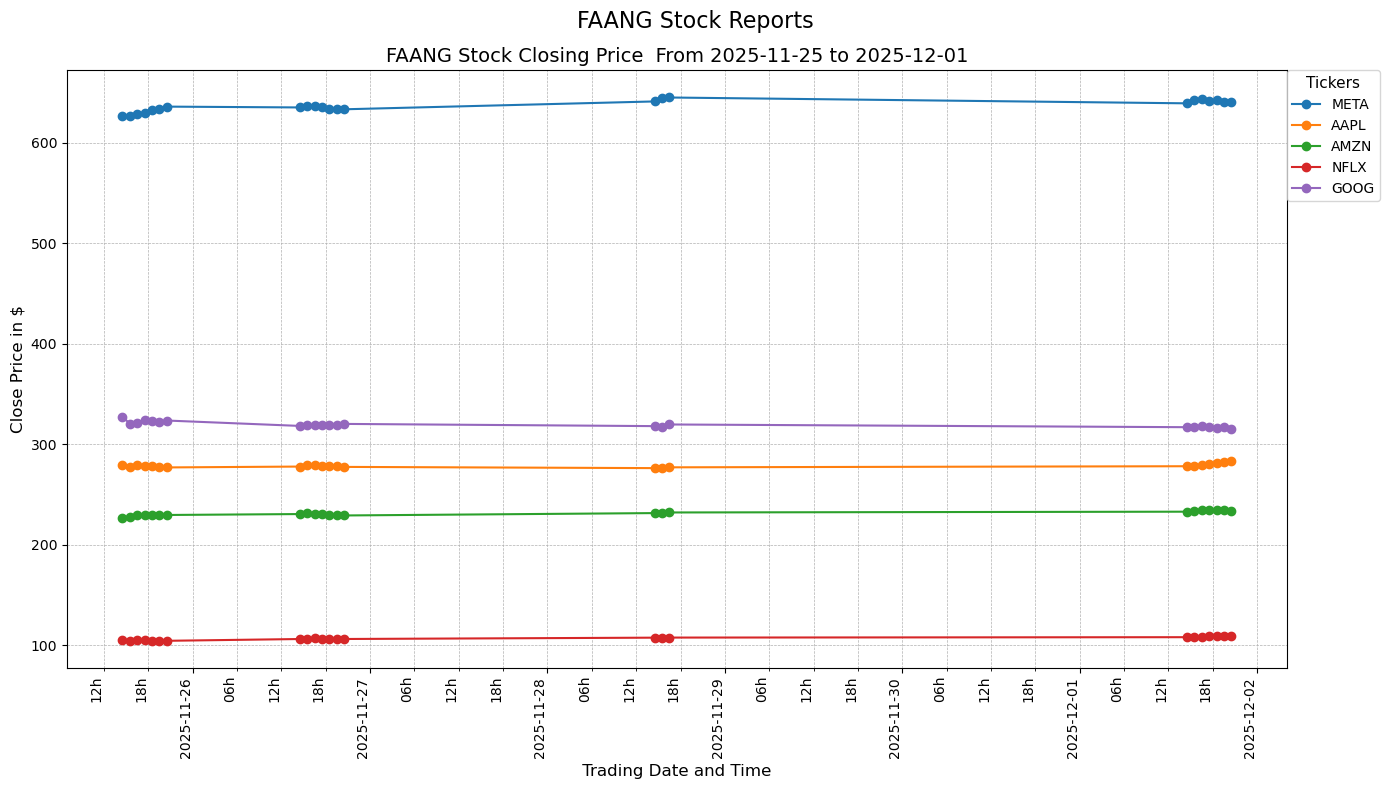

INFO:root:Plot saved to ./plots/20251202_203303.png


✓ Status: 0, Message: Plotting - Return Code: 0, Message: Success, File: ./plots/20251202_203303.png, File: Success


In [24]:
print("Smoke Test : Plotting")
return_code,return_message,filename = plot_data(show_plot=True)
print_status(return_code, f"Plotting - Return Code: {return_code}, Message: {return_message}, File: {filename}", return_message)


# Problem 3: Script #
Create a Python script called faang.py in the root of your repository. Copy the above functions into it and it so that whenever someone at the terminal types ./faang.py, the script runs, downloading the data and creating the plot. Note that this will require a shebang line and the script to be marked executable. Explain the steps you took in your notebook.

## Assignment: Problem 3 Requirements Specification##


**1. Script File Setup**

* [✅] Create a new file named faang.py.

* [✅] Ensure the file is saved in the root directory of the repository.

**2. Script Content & Structure**

* [✅] Add a "shebang" line at the very top (e.g., #!/usr/bin/env python3).

* [✅] Include all necessary import statements at the top (for yfinance, pandas, matplotlib, os, sys, etc.).

* [✅] Copy the get_data() function (from Problem 1) into the script.

* [✅] Copy the plot_data() function (from Problem 2) into the script.

* [✅] Include any helper functions needed by get_data or plot_data (like get_latest_file).

* [✅] Create a main() function to control the script's execution.

* [✅] Add the if __name__ == "__main__": block at the bottom to call the main() function.

**3. Script Execution Logic**

* [✅] Inside main(), ensure that get_data() is called first.

* [✅] Inside main(), ensure that plot_data() is called after get_data() successfully completes.

* [✅] Add error handling to stop the script if get_data() fails.

**4. Permissions & Running**

* [✅] The script must be made "executable" (using the chmod +x faang.py command in the terminal).

* [✅] The script must run successfully from the terminal when the user types ./faang.py.

**5. Documentation (Meta-Task)**

* [✅] Provide a separate explanation (e.g., in the notebook) detailing the steps taken to create the script, what the shebang line does, and how to make the script executable.

__Make Script Executable__

The current environment in a windows 11 laptop. To make the sure the file is executable on linux environments   
```
git update-index --chmod=+x faang.py   
git commit -m "Make script executable" 
```  

__She Bang Line__

The shebang line at the top of a unix/linux script tells the OS what shell/utility/program to use to run the script. 

```
#!/usr/bin/env python3
```

# Smoke Test

Import the "faang.py" module , and run the get_data() and plot_data() functions

INFO:root:File already exists for start date 2025-11-25, skipping download.
INFO:root:Starting data plotting...
INFO:root:Getting the latest file from ./data/
INFO:root:Latest file: ./data\20251202_203303.csv
INFO:root:Successfully loaded data from ./data\20251202_203303.csv. Shape: (24, 25)
INFO:root:Data covers from 2025-11-25 to 2025-12-01


✓ Status: 0, Message: Data Retrieval - Return Code: 0, Message: Success, File: ./data\20251202_203257.csv, File: Success


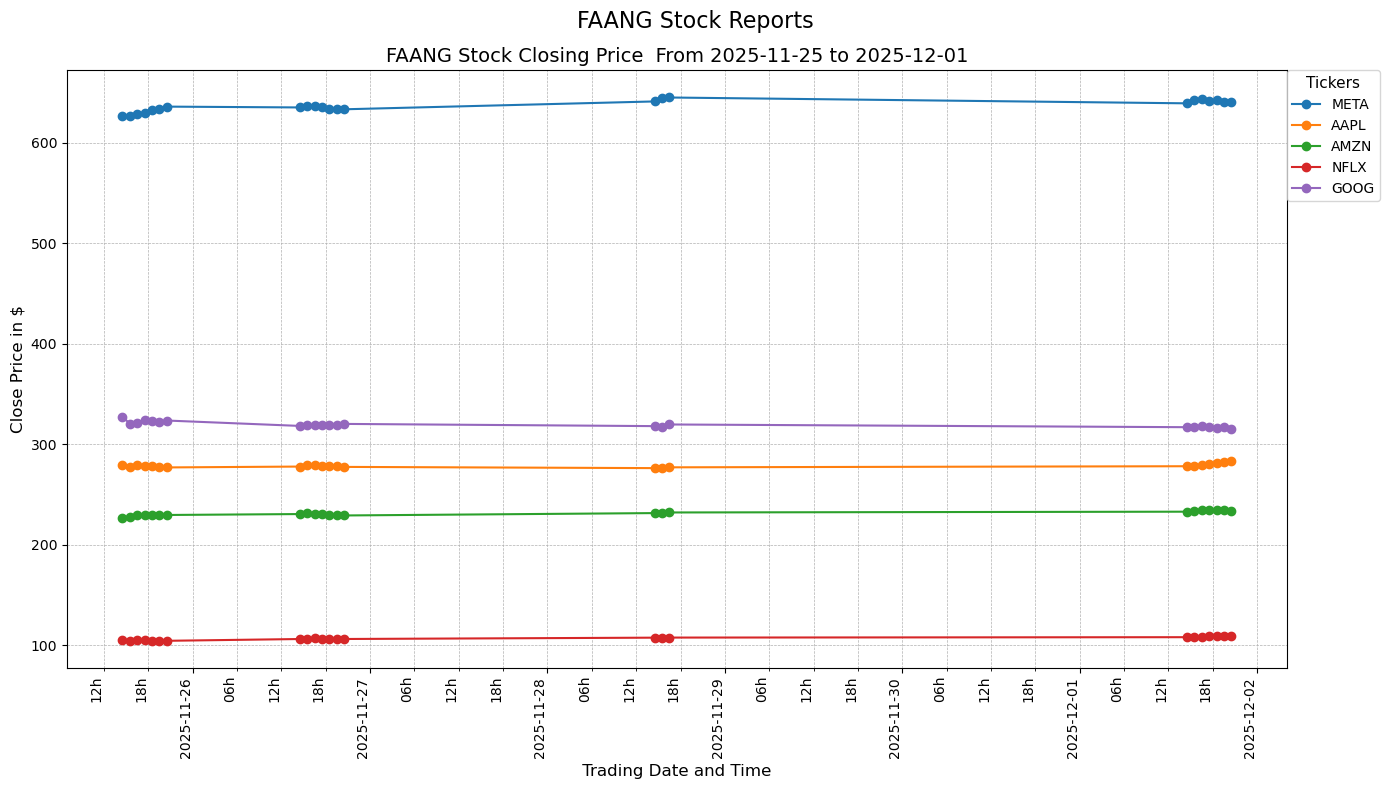

INFO:root:Plot saved to ./plots/20251202_203303.png


✓ Status: 0, Message: Plotting - Return Code: 0, Message: Success, File: ./plots/20251202_203303.png, File: Success


In [25]:
import faang as faang
# Smoke Test
# Import the "faang.py" module , and run the get_data() and plot_data() functions
return_code, return_message, file_name, df_data = faang.get_data()
print_status(return_code, f"Data Retrieval - Return Code: {return_code}, Message: {return_message}, File: {file_name}", return_message)
return_code, return_message, png_file_name = faang.plot_data(show_plot=True)
print_status(return_code, f"Plotting - Return Code: {return_code}, Message: {return_message}, File: {png_file_name}", return_message)

__The End__